In [14]:
"""
This Program Evaluates and Predicts O-PPAC data using a Fully Connected Neural Network
@author: Ted Yoo
"""

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [ ]:
# Takes (9,132,1011) dataset from Yassid and compiles it into a (9099,132) set.
def data_compile(histdata, x_pos):
    data = []
    labels = []
    for i in range(histdata.shape[0]):
        for j in range(1,histdata.shape[2]):
            data.append(histdata[i,0:132,j])
            labels.append(x_pos[i])
    return(np.array(data),np.array(labels))

In [ ]:
#Splits all data into Train, Validation and Test based on input percentages of test_split and val_split
def data_split(dataset,labels,test_split, val_split):
    temp_data, test_data, temp_labels, test_labels = train_test_split(all_data, all_labels, test_size=test_split,shuffle=True)
    train_data, val_data, train_labels, val_labels = train_test_split(temp_data, temp_labels, test_size=val_split,shuffle=True)
    return train_data, val_data, test_data, train_labels, val_labels, test_labels


In [18]:
#Scales Train, Validation and Test based on specified scaler_type
def scaler(scaler_type, train, val, test):
    scaler_type.fit(train)
    train = scaler_type.transform(train)
    val = scaler_type.transform(val)
    test = scaler_type.transform(test)
    return (train, val, test)

In [19]:
#Trains Model and Evaluates based on Test, Validation, Train inputs
def train_model(trainData, trainLabels, valData, valLabels, test_data, test_labels): 
    FCNN_model = tf.keras.Sequential()
    FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
    FCNN_model.add(layers.Dense(256, activation = 'relu'))
    FCNN_model.add(layers.Dropout(0.5))
    FCNN_model.add(layers.Dense(1, activation = 'linear'))
    FCNN_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=100,
                    batch_size = 32,
                    #callbacks = [callback],
                    validation_data = (val_data,val_labels)
                    )
    result = FCNN_model.evaluate(test_data, test_labels, verbose=2)
    predictions = FCNN_model.predict(test_data)
    return(FCNN_history, result, predictions)

In [ ]:
%tensorboard --logdir logs/fit

In [20]:
def main():
    #Extracts data from h5 file
    dataset = h5py.File('simu_HDF_new.h5', 'r')
    num_diodes = dataset['Num_diodes'][...]
    x_pos = (dataset['Xpos'][...])/100
    y_pos = dataset['Ypos'][...]
    histgrid = dataset['histgrid'][...]
    dataset.close()
    
    #Defines Scalers used to scale inputs and outputs
    input_scaler = MinMaxScaler()
    output_scaler = StandardScaler()
    
    #Put Compile all data and their labels
    all_data, all_labels = data_compile(histgrid, x_pos)
    
    #Split Train, Validation and Test datasets
    train_data, val_data, test_data, train_labels, val_labels, test_labels = data_split(all_data, all_labels, 0.2, 0.25)
    
    #Reshape Labels for Scaling
    train_labels = train_labels.reshape(-1,1)
    val_labels = val_labels.reshape(-1,1)
    test_labels = test_labels.reshape(-1,1)
    
    #Scale both Inputs and Outputs
    train_data, val_data, test_data = scaler(input_scaler, train_data, val_data, test_data)
    train_labels, val_labels, test_labels = scaler(output_scaler, train_labels, val_labels, test_labels)
    
    #Train and Evaluate Fully Connect Neural Network Model
    FCNN_history, result, predictions = train_model(train_data, train_labels, val_data, val_labels, test_data, test_labels)
    
    #Inverse Transform scaled Labels and Predictions
    test_rescale_labels = output_scaler.inverse_transform(test_labels)
    predictions_rescale = output_scaler.inverse_transform(predictions)
    
    #Plot Loss Curve
    plt.figure(1)
    plt.plot(FCNN_history.history['loss'], label='loss')
    plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 0.1])
    plt.legend(loc='upper right')
    plt.title("FCNN O-PPAC Loss Curve")
    
    #Plot Predictions vs True Values
    plt.figure(2)
    a = plt.axes(aspect='equal')
    plt.scatter(test_rescale_labels, predictions_rescale)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    lims = [-50, 50]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.title("FCNN O-PPAC Predictions vs True Values")

Train on 5454 samples, validate on 1818 samples
Epoch 1/100
5454/5454 [==============================] - 1s 198us/sample - loss: 0.0640 - mae: 0.1764 - mse: 0.0640 - val_loss: 0.0233 - val_mae: 0.1173 - val_mse: 0.0233
Epoch 2/100
5454/5454 [==============================] - 1s 128us/sample - loss: 0.0307 - mae: 0.1247 - mse: 0.0307 - val_loss: 0.0093 - val_mae: 0.0691 - val_mse: 0.0093
Epoch 3/100
5454/5454 [==============================] - 1s 130us/sample - loss: 0.0254 - mae: 0.1118 - mse: 0.0254 - val_loss: 0.0185 - val_mae: 0.1094 - val_mse: 0.0185
Epoch 4/100
5454/5454 [==============================] - 1s 122us/sample - loss: 0.0199 - mae: 0.0982 - mse: 0.0199 - val_loss: 0.0161 - val_mae: 0.0931 - val_mse: 0.0161
Epoch 5/100
5454/5454 [==============================] - 1s 126us/sample - loss: 0.0185 - mae: 0.0935 - mse: 0.0185 - val_loss: 0.0065 - val_mae: 0.0555 - val_mse: 0.0065
Epoch 6/100
5454/5454 [==============================] - 1s 124us/sample - loss: 0.0169 - mae: 0.

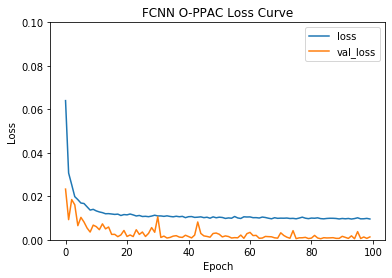

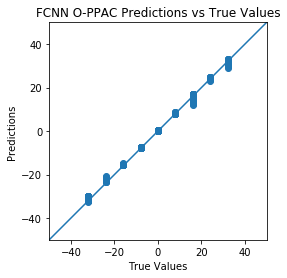

In [21]:
if __name__ == "__main__":
    main()